## Business Licenses

### All datasets sourced on October 15

#### Food

The Health Division of the Department of Inspectional Services (ISD) creates and enforces food safety codes to protect public health. All businesses which prepare and sell food to the public must possess a food service permit. In order to qualify for a permit, at least one full time employee must be must be certified through an accredited food manager program, which provides guidance on handling and serving food to the public.

#### Alcohol

The Licensing Board for the City of Boston enforces alcohol license law under Section 12 and Section 15, Chapter 138 of the Massachusetts General Laws. Alcohol licenses are issued by the City of Boston Licensing Board and approved by the Massachusetts Alcohol Beverage Control Commission. Licenses are broken down into location and beverage types. Retail location licenses for off-premises consumption include package stores, supermarkets, and convenience stores. On-premises consumption licenses cover restaurants, clubs, hotels, taverns, and general on-premises establishments.

#### Cannabis

This Open Data Registry includes currently licensed applicants as well as pending cannabis license applicants.

#### General Licensing

The Licensing Board issues a variety of license under MGL Chapter 138 and Chapter140 including Billiards, Bowling, Clubs/Veterans' Groups, Common Victualler (Food Service), Alcohol Beverage, Innholder, Dormitories/Lodging houses, and Retail Package Stores. This dataset lists all licenses that are currently active.

In [1]:
import pandas as pd
from pyproj import Proj, transform
import folium
from folium.plugins import HeatMap
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib.parse
df_food = pd.read_csv("active_food_est_licenses.csv")
df_food.index.title = "Food Licenses"
df_liquor = pd.read_csv("liquor_licenses.csv")
df_liquor.index.title = "Liquor Licenses"
df_cannabis = pd.read_csv("Cannabis_Registry.csv")
df_cannabis.index.title = "Cannabis Licenses"
df_licensing = pd.read_csv("licensing_board.csv")
df_licensing.index.title = "General Licenses"

In [2]:
print(df_food.keys())
df_food = df_food.drop(['LICSTATUS'], axis = 1)
fulladdr = []
for i in list(zip(df_food['Address'], df_food['CITY'], df_food['State'], df_food['ZIP'])):
    fulladdr.append(f"{i[0]}, {i[1]}, {i[2]}, {i[3]}")
df_food['fulladdress'] = fulladdr
df_food

Index(['BusinessName', 'DBAName', 'Address', 'CITY', 'State', 'ZIP',
       'LICSTATUS', 'LICENSECAT', 'DESCRIPT', 'LicenseAddDtTm', 'dayphn',
       'Property_ID', 'Latitude', 'Longitude'],
      dtype='object')


,BusinessName,DBAName,Address,CITY,State,ZIP,LICENSECAT,DESCRIPT,LicenseAddDtTm,dayphn,Property_ID,Latitude,Longitude,fulladdress
0,# 7 RESTAURANT,NaN,225 Grove,West Roxbury,MA,02132,FT,Eating & Drinking w/ Take Out,2007-03-23 15:20:59,10000000000,156965.0,42.261873,-71.157410,"225 Grove, West Roxbury, MA, 02132"
1,100 Federal Market & Barista- 11th Floor,NaN,100 Federal,Boston,MA,02110,FT,Eating & Drinking w/ Take Out,2021-01-12 10:37:24,16174345000,57150.0,42.354770,-71.056130,"100 Federal, Boston, MA, 02110"
2,100 Percent Delicias Express,NaN,656 Centre,Jamaica Plain,MA,02130,FT,Eating & Drinking w/ Take Out,2017-11-28 10:27:47,18572505689,28152.0,42.312830,-71.113860,"656 Centre, Jamaica Plain, MA, 02130"
3,11 Dining -16th Fl.,NaN,200 Berkeley,Boston,MA,02116,FS,Eating & Drinking,2019-12-20 09:32:17,10000000000,187943.0,42.349860,-71.072910,"200 Berkeley, Boston, MA, 02116"
4,110 Grill,NaN,25 Jan Karski,Dorchester,MA,02125,FS,Eating & Drinking,2018-11-29 14:14:04,19786929450,421286.0,0.000000,0.000000,"25 Jan Karski, Dorchester, MA, 02125"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,ZESTO'S PIZZA,NaN,460 Centre,Jamaica Plain,MA,02130,FT,Eating & Drinking w/ Take Out,2011-04-28 08:54:10,16175242004,28061.0,42.319350,-71.111540,"460 Centre, Jamaica Plain, MA, 02130"
3027,Ziggy's,NaN,583 Washington,Brighton,MA,02135,FT,Eating & Drinking w/ Take Out,2020-10-23 12:17:07,16178333508,351055.0,0.000000,0.000000,"583 Washington, Brighton, MA, 02135"
3028,Zo,NaN,92 State,Boston,MA,02109,FT,Eating & Drinking w/ Take Out,2011-12-16 09:44:46,16179016017,170003.0,42.359232,-71.055320,"92 State, Boston, MA, 02109"
3029,Zuma Restaurant,NaN,1 Dalton,Boston,MA,02115,FS,Eating & Drinking,2018-02-16 10:18:58,18574492500,351070.0,0.000000,0.000000,"1 Dalton, Boston, MA, 02115"


In [3]:
print(df_liquor.keys())

fulladdr = []
for i in list(zip(df_liquor['address'], df_liquor['city'], df_liquor['state'], df_liquor['zip'])):
    fulladdr.append(f"{i[0]}, {i[1]}, {i[2]}, {i[3]}")
df_liquor['fulladdress'] = fulladdr

def getcoords(address):
    """
    Returns coordinates given address. This is particularly slow since we are calling the API each time we want
    the address, and does not always provide a valid response, so it may be worth removing if not keen on
    plotting every single license
    """
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    response = requests.get(url).json()
    if response:
        return (float(response[0]["lon"]), float(response[0]["lat"]))

inProj = Proj(init='epsg:2249', preserve_units = True)
outProj = Proj(init='epsg:4326')

bruh = []
for i in df_liquor[['gpsx', 'gpsy', 'fulladdress']].values:
    value = transform(inProj,outProj, i[0], i[1])
    if np.isnan(value[0]) or np.isnan(value[1]):
        tempval = getcoords(i[2])
        if tempval:
            value = tempval
    bruh.append(value)
    
bruh = list(zip(*bruh))

df_liquor['Latitude'] = bruh[1]
df_liquor['Longitude'] = bruh[0]

df_liquor = df_liquor.drop(['gpsx', 'gpsy'], axis = 1)
df_liquor

Index(['license_num', 'historicallicensenum', 'status', 'license_type',
       'issued', 'expires', 'business_name', 'dba_name', 'comments',
       'location_comments', 'opening', 'closing', 'patronsout', 'capacity',
       'applicant', 'manager', 'day_phone', 'evening_phone', 'address', 'city',
       'state', 'zip', 'gpsx', 'gpsy'],
      dtype='object')


/Users/rithvikdoshi/miniforge3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/rithvikdoshi/miniforge3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/h4/9f2v44n1193bjy0bstpgw5k00000gp/T/ipykernel_43443/769889180.py:24: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html

,license_num,historicallicensenum,status,license_type,issued,expires,business_name,dba_name,comments,location_comments,...,manager,day_phone,evening_phone,address,city,state,zip,fulladdress,Latitude,Longitude
0,LB-485386,NaN,Active,Retail Malt Wine,NaN,NaN,Dorchester Market LLC,Dorchester Market,NaN,Accessory retail sales of wine & malt beverage...,...,Peter McGee,(617)238-7406,NaN,951- Dorchester AV,Dorchester,MA,02125,"951- Dorchester AV, Dorchester, MA, 02125",42.318251,-71.057002
1,LB-481088,NaN,Active,CV7ALN - Neighborhood Restricted,2022-09-29,2022-12-31,Yak Thai Inc.,Thonglor,NaN,"1,000SF: in one room on first floor (seating f...",...,Piyapong Wongla,(781)472-0835,NaN,559- Washington ST,Brighton,MA,02135,"559- Washington ST, Brighton, MA, 02135",42.349489,-71.163705
2,LB-476655,NaN,Active,CV7ALN - Neighborhood Restricted,2022-09-26,2022-12-31,HOMESTEAD BAKERY & CAFE LLC,NaN,NaN,homestead bakery & cafe LLC is located on the ...,...,Annie Le,(617)858-0468,NaN,1448- Dorchester AVE,Dorchester,MA,02122,"1448- Dorchester AVE, Dorchester, MA, 02122",42.301140,-71.059750
3,LB-445763,NaN,Active,Retail Malt Wine,2022-08-30,2022-12-31,Grove Hall Foods Corp.,Grove Hall Convenience Market II,NaN,NaN,...,Edward Guerrero,(617)708-0775,NaN,292- Talbot AVE,Boston,MA,02124,"292- Talbot AVE, Boston, MA, 02124",42.291040,-71.074360
4,LB-469486,NaN,Active,Retail Malt Wine,2022-08-24,2022-12-31,Rupal Corporation,J&J Discount Mini Mart,No singles,Premise is located at 131 West Broadway South ...,...,Michael David Gannon,(617)268-0455,NaN,131- W Broadway,South Boston,MA,02127,"131- W Broadway , South Boston, MA, 02127",42.340797,-71.054339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,LB-101595,GOPWM0001,Active,GOP Malt Wine,2013-10-01,2022-12-31,LYRIC STAGE COMPANY,LYRIC STAGE,11 00 M to P,140 CLARENDON STREET; ON THE SECOND FLOOR THEA...,...,Matt Chapuran,NaN,776-8280,140- Clarendon ST,Boston,MA,02116,"140- Clarendon ST, Boston, MA, 02116",42.348612,-71.074438
1442,LB-101596,GOPWM0004,Active,GOP Malt Wine Liq.,2013-10-01,2022-12-31,"BOSTON CULINARY GROUP, INC.",THE ORPHEUM THEATRE,1 CONSUMPTION ALCOHOL ALLOWED IN SEATING AREA ...,"IN WHOLE OF ORPHEUM THEATRE, INCLUDING BAR SER...",...,Sean O'Dwyer,NaN,(781)659-9923,1- Hamilton Pl,Boston,MA,02108,"1- Hamilton Pl, Boston, MA, 02108",42.356205,-71.060941
1443,LB-101611,GOPWML0009,Active,GOP Malt Wine Liq.,2013-10-01,2022-12-31,"EMANUEL ENTERPRISES, LLC",NaN,NaN,Entrance on first floor; one room on first fl...,...,EDGAR OSPINA,NaN,(617)608-0899,71-73 Meridian ST,East Boston,MA,02128,"71-73 Meridian ST, East Boston, MA, 02128",42.371967,-71.038818
1444,LB-98819,CLBALA0002,Active,Clb. All Alc. Airport,2013-10-01,2022-12-31,"AMERICAN AIRLINES, INC.",ADMIRALS CLUB,NaN,"Approximately 15,317 Sq. Ft. retail space with...",...,Susan Namdar,NaN,(781)944-1506,"Logan Airport, Terminal B",East Boston,MA,02128,"Logan Airport, Terminal B , East Boston...",NaN,NaN


In [4]:
print(df_cannabis.keys())

addr = df_cannabis['Facility_Address'].map(lambda x: x.split(","))
street = addr.map(lambda x: x[0].replace("\n", " ").strip())
city = addr.map(lambda x: x[-2].strip())
state = addr.map(lambda x: 'MA')
zipcode = addr.map(lambda x: x[-1][-5:] if len(x[-1]) > 5 else np.nan)
df_cannabis['street'] = street
df_cannabis['city'] = city
df_cannabis['state'] = state
df_cannabis['zip'] = zipcode

x_copy = df_cannabis['x']
df_cannabis['x'] = df_cannabis['y']
df_cannabis['y'] = x_copy

df_cannabis

Index(['Application_Status', 'Facility_Address', 'Main_Entity_Name',
       'Seeking_Bos_Equity_Program', 'Submitted_Date', 'Trade_Name_DBA',
       'Type_of_Marijuana_License', 'x', 'y', 'SAM_ID', 'updated_timestamp',
       'ObjectId'],
      dtype='object')


,Application_Status,Facility_Address,Main_Entity_Name,Seeking_Bos_Equity_Program,Submitted_Date,Trade_Name_DBA,Type_of_Marijuana_License,x,y,SAM_ID,updated_timestamp,ObjectId,street,city,state,zip
0,Approved BCB - Executed HCA - Pending CCC,"144 Bowdoin St, Dorchester, MA","617 Therapeutic Health Care, Inc..",No,10/10/2018,NaN,Adult use dispensary,42.303849,-71.071131,42227.0,2022/03/22 19:59:53.102+00,1,144 Bowdoin St,Dorchester,MA,NaN
1,Open for Operations,"54A Hyde Park Ave, Jamaica Plain, MA","Apothca, Inc",No,5/24/2018,"Massachusetts Patient Foundation, Inc.",Medical,42.298577,-71.114390,NaN,2022/03/22 19:59:53.102+00,2,54A Hyde Park Ave,Jamaica Plain,MA,NaN
2,Open for operation,"54a Hyde Park Ave, JamaicaPlain, Massachusetts...","Apothca, Inc. f/k/a Massachusetts Patient Foun...",No,NaN,"Apothca, Inc.",Co-located recreational and medical cannabis d...,42.298577,-71.114390,NaN,2022/10/06 02:45:10.435+00,3,54a Hyde Park Ave,JamaicaPlain,MA,02130
3,Open for Operations,"268-274 Friend St, West End, MA",Ascend Mass LLC,No,5/3/2018,NaN,Adult use dispensary,42.364669,-71.061431,154992.0,2022/03/22 19:59:53.102+00,4,268-274 Friend St,West End,MA,NaN
4,Conditionally approved,"1524 VFW Parkway, WestRoxbury, Massachusetts 0...","Beacon Compassion, Inc",No,NaN,Beacon Compassion,Co-located recreational and medical cannabis d...,42.268310,-71.170383,140314.0,2022/10/06 02:45:10.435+00,5,1524 VFW Parkway,WestRoxbury,MA,02132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Approved,"116 Cambridge Street, Charlestown, Massachuset...",The Heritage Club LLC,Yes,NaN,The Heritage Club,Recreational retail cannabis dispensary,42.382139,-71.079531,25075.0,2022/10/06 02:45:10.435+00,59,116 Cambridge Street,Charlestown,MA,02129
59,Approved BCB - Executed HCA - Pending CCC,"259 Cambridge St, Allston, MA","Union Twist, Inc..\n",No,12/5/2018,NaN,Adult use dispensary,42.357619,-71.128041,64168.0,2022/03/22 19:59:53.102+00,60,259 Cambridge St,Allston,MA,NaN
60,Approved,"150 State Street, Boston, Massachusetts 02109","Verdant Reparative, Inc.",Yes,NaN,Apex Noire,Recreational retail cannabis dispensary;Produc...,42.359415,-71.054071,357190.0,2022/10/06 02:45:10.435+00,61,150 State Street,Boston,MA,02109
61,Approved,"888 Morton St, Mattapan, Massachusetts 02126",Xhale New England Dispensary,Yes,NaN,Xhale New England Dispensary,Recreational retail cannabis dispensary,42.280999,-71.084071,386884.0,2022/10/06 02:45:10.435+00,62,888 Morton St,Mattapan,MA,02126


In [5]:
print(df_licensing.keys())

inProj = Proj(init='epsg:2249', preserve_units = True)
outProj = Proj(init='epsg:4326')

bruh = []
for i in df_licensing[['gpsx', 'gpsy']].values:
    bruh.append(transform(inProj,outProj, i[0], i[1]))

bruh = list(zip(*bruh))

df_licensing['Latitude'] = bruh[1]
df_licensing['Longitude'] = bruh[0]

df_licensing = df_licensing.drop(['gpsx', 'gpsy'], axis = 1)
df_licensing

Index(['license_num', 'historicallicensenum', 'status', 'license_category',
       'license_type', 'issued', 'expires', 'business_name', 'dba_name',
       'comments', 'location_comments', 'opening', 'closing', 'patronsout',
       'capacity', 'applicant', 'manager', 'day_phone', 'evening_phone',
       'address', 'city', 'state', 'zip', 'gpsx', 'gpsy'],
      dtype='object')


/Users/rithvikdoshi/miniforge3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/rithvikdoshi/miniforge3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/h4/9f2v44n1193bjy0bstpgw5k00000gp/T/ipykernel_43443/762746844.py:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#

,license_num,historicallicensenum,status,license_category,license_type,issued,expires,business_name,dba_name,comments,...,applicant,manager,day_phone,evening_phone,address,city,state,zip,Latitude,Longitude
0,LB-485386,NaN,Active,Misc,Retail Malt Wine,NaN,NaN,Dorchester Market LLC,Dorchester Market,NaN,...,Dorchester Market LLC,Peter McGee,(617)238-7406,NaN,951- Dorchester AV,Dorchester,MA,02125,42.318251,-71.057002
1,LB-481806,NaN,Active,CV,Common Victualler,2022-10-13,2022-12-31,"Food's Style USA, Inc.",Hokkaido Ramen Santouka,NaN,...,"Food's Style USA, Inc.",Tatsunori Tanaka,(206)889-2069,NaN,169- Brighton AVE,Allston,MA,02134,42.353291,-71.132319
2,LB-492447,NaN,Active,CV,Common Victualler,2022-10-03,2022-12-31,Tori EB Food Inc.,Tori Japan,NaN,...,Tori EB Food Inc.,Min Zhu,(781)609-8753,NaN,62- William C Kelly SQ,East Boston,MA,02128,42.374322,-71.039939
3,LB-481088,NaN,Active,CV,CV7ALN - Neighborhood Restricted,2022-09-29,2022-12-31,Yak Thai Inc.,Thonglor,NaN,...,Yak Thai Inc.,Piyapong Wongla,(781)472-0835,NaN,559- Washington ST,Brighton,MA,02135,42.349489,-71.163705
4,LB-423922,NaN,Active,CV,Common Victualler,2022-09-28,2022-12-31,"PNR, LLC",PICK N' ROLL SUSHI,Hours Operation Monday Saturday 11 00 AM 8 PM,...,"PNR, LLC",Victor Choi,(617)251-5829,NaN,134- Boylston ST,Boston,MA,02116,42.352280,-71.066130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3324,LB-107538,NaN,Active,Misc,Dormitory,2013-09-16,2023-04-30,TRUSTEES OF BOSTON UNIVERSITY,BOSTON UNIVERSITY,No Conditions,...,Trustees of Boston University,NISHMIN KASHYAP,(617)353-2148,(617)353-2148,826- Beacon ST,Boston,MA,02215,42.347560,-71.102737
3325,LB-107590,NaN,Active,Misc,Dormitory,2013-09-16,2023-04-30,TRUSTEES OF BOSTON UNIVERSITY,BOSTON UNIVERSITY,No Conditions,...,Trustees of Boston University,NISHMIN KASHYAP,(617)353-2148,(617)353-2148,844-844A Beacon ST,Boston,MA,02215,42.347410,-71.103630
3326,LB-108942,NaN,Active,CV,Common Victualler,2013-09-04,2022-12-31,"WHOLE FOODS MARKET GROUP, INC.",Whole Foods Market,NaN,...,"Whole Foodsmarket Group, Inc.",Dorothy Pumphrey,(617)492-5500,NaN,27- Austin St,Charlestown,MA,02129,42.375474,-71.066288
3327,LB-109265,NaN,Active,CV,Common Victualler,2013-08-30,2022-12-31,"Sultana's Bakery & Cafe, LLC","Boston Croissant Bakery, Cafe",1 7 00 AM PM Mon Sat 9 6 on Sundays,...,"Sultana's Bakery & Cafe, LLC",Lale Dogar,(617)202-5454,NaN,1585- Commonwealth AVE,Brighton,MA,02135,42.344263,-71.143070


In [6]:
licenseMap = folium.Map(location = [42.361145, -71.057083], zoom_start=11)

In [7]:
for i in list(zip(df_food['Latitude'], df_food['Longitude'])):
    if not (np.isnan(i[0]) or np.isnan(i[1])):
        folium.CircleMarker(location = [i[0], i[1]], radius=5, color='blue').add_to(licenseMap)
for i in list(zip(df_liquor['Latitude'], df_liquor['Longitude'])):
    if not (np.isnan(i[0]) or np.isnan(i[1])):
        folium.CircleMarker(location = [i[0], i[1]], radius=8, color='yellow').add_to(licenseMap)
for i in list(zip(df_cannabis['x'], df_cannabis['y'])):
    if not (np.isnan(i[0]) or np.isnan(i[1])):
        folium.CircleMarker(location = [i[0], i[1]], radius=10, color='lime').add_to(licenseMap)
for i in list(zip(df_licensing['Latitude'], df_licensing['Longitude'])):
    if not (np.isnan(i[0]) or np.isnan(i[1])):
        folium.CircleMarker(location = [i[0], i[1]], radius=1, color='red').add_to(licenseMap)
licenseMap.save('map.html')

In [8]:
def plotvalcounts(df, label):
    df[label] = df[label].copy().apply(lambda x: str(x).lower().replace(" ", "").replace("/", ""))
    uniquevals = df[label].value_counts()
    fig, ax = plt.subplots()
    ax.bar(uniquevals.keys(), uniquevals.values)
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
    plt.title(f"{df.index.title} per {label}")
    plt.show()
    print(uniquevals)

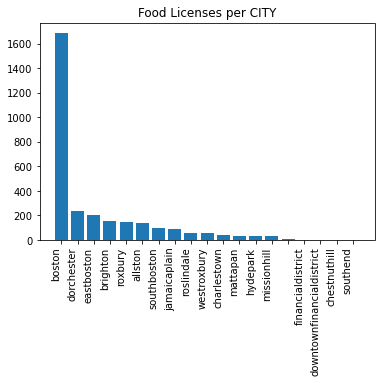

boston                       1686
dorchester                    238
eastboston                    208
brighton                      153
roxbury                       149
allston                       138
southboston                    95
jamaicaplain                   93
roslindale                     60
westroxbury                    57
charlestown                    38
mattapan                       36
hydepark                       34
missionhill                    32
                                5
financialdistrict               4
downtownfinancialdistrict       2
chestnuthill                    2
southend                        1
Name: CITY, dtype: int64


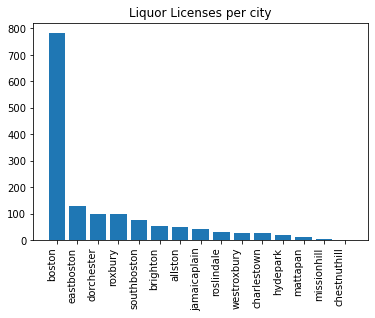

boston          783
eastboston      127
dorchester      100
roxbury          98
southboston      77
brighton         53
allston          48
jamaicaplain     42
roslindale       32
westroxbury      27
charlestown      25
hydepark         18
mattapan         11
missionhill       3
chestnuthill      2
Name: city, dtype: int64


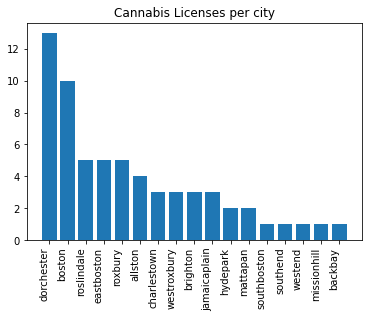

dorchester      13
boston          10
roslindale       5
eastboston       5
roxbury          5
allston          4
charlestown      3
westroxbury      3
brighton         3
jamaicaplain     3
hydepark         2
mattapan         2
southboston      1
southend         1
westend          1
missionhill      1
backbay          1
Name: city, dtype: int64


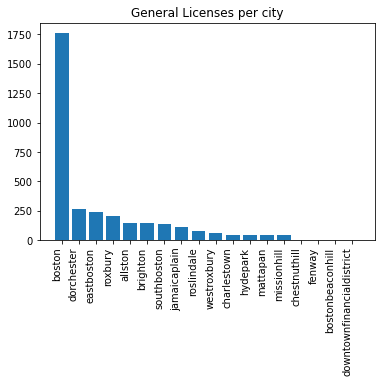

boston                       1763
dorchester                    267
eastboston                    236
roxbury                       208
allston                       148
brighton                      141
southboston                   135
jamaicaplain                  114
roslindale                     77
westroxbury                    61
charlestown                    47
hydepark                       43
mattapan                       43
missionhill                    39
chestnuthill                    4
fenway                          1
bostonbeaconhill                1
downtownfinancialdistrict       1
Name: city, dtype: int64


In [9]:
plotvalcounts(df_food, 'CITY')
plotvalcounts(df_liquor, 'city')
plotvalcounts(df_cannabis, 'city')
plotvalcounts(df_licensing, 'city')

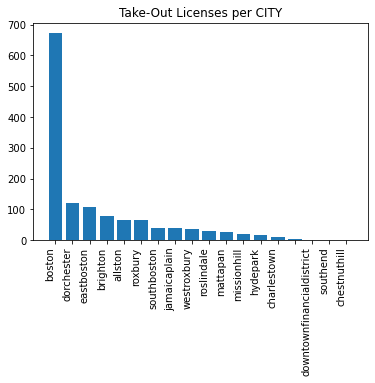

boston                       673
dorchester                   121
eastboston                   108
brighton                      79
allston                       66
roxbury                       65
southboston                   38
jamaicaplain                  38
westroxbury                   36
roslindale                    31
mattapan                      26
missionhill                   19
hydepark                      17
charlestown                   10
                               4
downtownfinancialdistrict      1
southend                       1
chestnuthill                   1
Name: CITY, dtype: int64


In [10]:
take_out = df_food[df_food['DESCRIPT'] == "Eating & Drinking w/ Take Out"].reset_index()
take_out.index.title = "Take-Out Licenses"
plotvalcounts(take_out, 'CITY')

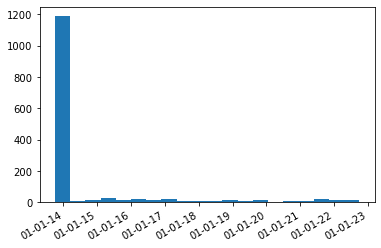

In [11]:
import matplotlib.dates as mdates
dt = pd.to_datetime(df_liquor['issued'])
fig, ax = plt.subplots()
fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%m-%d-%y')
ax.xaxis.set_major_formatter(xfmt)
ax.hist(dt, 20)
plt.show()

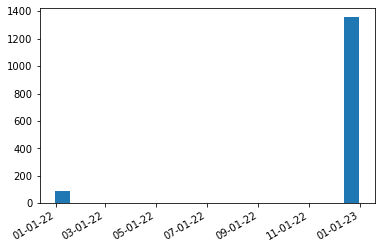

In [12]:
dt = pd.to_datetime(df_liquor['expires'])
fig, ax = plt.subplots()
fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%m-%d-%y')
ax.xaxis.set_major_formatter(xfmt)
ax.hist(dt, 20)
plt.show()

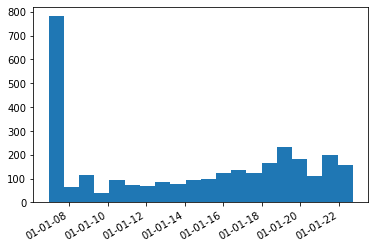

In [13]:
dt = pd.to_datetime(df_food['LicenseAddDtTm'])
fig, ax = plt.subplots()
fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%m-%d-%y')
ax.xaxis.set_major_formatter(xfmt)
ax.hist(dt, 20)
plt.show()

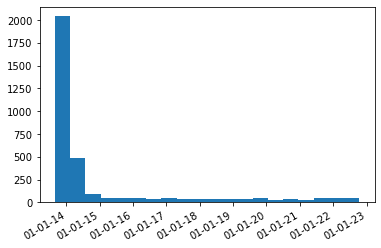

In [14]:
dt = pd.to_datetime(df_licensing['issued'])
fig, ax = plt.subplots()
fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%m-%d-%y')
ax.xaxis.set_major_formatter(xfmt)
ax.hist(dt, 20)
plt.show()

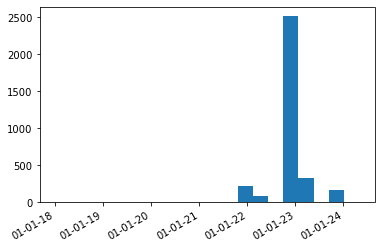

In [15]:
dt = pd.to_datetime(df_licensing['expires'])
fig, ax = plt.subplots()
fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%m-%d-%y')
ax.xaxis.set_major_formatter(xfmt)
ax.hist(dt, 20)
plt.show()

In [16]:
df_cannabis.to_csv("../../deliverable3/data/business_licenses/df_cannabis.csv")

In [17]:
df_food.to_csv("../../deliverable3/data/business_licenses/df_food.csv")

In [18]:
df_licensing.to_csv("../../deliverable3/data/business_licenses/df_licensing.csv")

In [19]:
df_liquor.to_csv("../../deliverable3/data/business_licenses/df_liquor.csv")